In [48]:
# Import necessary libraries
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
from collections import deque

import torch
import torch.nn as nn

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, VecMonitor
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.policies import ActorCriticCnnPolicy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.preprocessing import get_flattened_obs_dim
from stable_baselines3.common.callbacks import EvalCallback

from utils.fetch_data_with_indicators import Api, fetch_data_with_indicators

In [ ]:
# ====================================
# Load Data
# ====================================

data = fetch_data_with_indicators(Api.YAHOO, 'BTC-USD', '2015-01-01', '2023-01-01', '1d', ['RSI', 'EMA_50'])

data = data.copy()  # Make a full copy
data['Pct Change'] = data['Close'].pct_change() * 100
data.dropna(inplace=True)

print(data.head())

# Define number of features (used in observation space)
num_features = 5

# ====================================
# Custom Environment Definition
# ====================================

class CryptoTradingEnv(gym.Env):
    def __init__(self, df, window_size=10, initial_balance=1000, render_mode='human'):
        super(CryptoTradingEnv, self).__init__()
        
        self.df = df.reset_index(drop=True)
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.current_step = 0
        self.render_mode = render_mode
        
        self.actions_history = self.df[['Close', 'RSI']].copy()
        self.actions_history['Action'] = 0
        
        self._last_reward = 0
        self._last_action = 0
        self._balance_pct_buy = 0.1
        self._avg_buy_price = 0
        self._avg_sell_price = 0
        
        self.balance = initial_balance
        self.crypto_held = 0
        self.net_worth = initial_balance
        
        self.action_space = spaces.Discrete(3)  # 0: Hold, 1: Buy, 2: Sell
        
        # Observation space: historical data + portfolio state
        self.observation_space = spaces.Dict({
            'prices': spaces.Box(low=-np.inf, high=np.inf, shape=(self.window_size, num_features), dtype=np.float32),
            'portfolio': spaces.Box(low=0, high=np.inf, shape=(3,), dtype=np.float32),  # balance, crypto_held, net_worth
        })
        
        self.price_history = deque(maxlen=self.window_size)
        self._seed()
    
    def _seed(self, seed=None):
        np.random.seed(seed)
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.crypto_held = 0
        self.net_worth = self.initial_balance
        
        self.actions_history = self.df[['Close', 'RSI']].copy()
        self.actions_history['Action'] = 0
        
        self._last_reward = 0
        self._last_action = 0
        self._balance_pct_buy = 0.1
        self._avg_buy_price = 0
        self._avg_sell_price = 0
        
        self.price_history.clear()
        for i in range(self.current_step - self.window_size, self.current_step):
            self.price_history.append(self._get_price_features(i))
        
        return self._get_observation(), {}
    
    def _get_price_features(self, index):
        return self.df.loc[index, ['Close', 'Volume', 'RSI', 'EMA_50', 'Pct Change']].values.astype(np.float32)
    
    def _get_observation(self):
        obs = {
            'prices': np.array(self.price_history),
            'portfolio': np.array([
                self.balance,
                self.crypto_held,
                self.net_worth,
            ], dtype=np.float32)
        }
        return obs
    
    def _get_info(self):
        return dict(
            balance=self.balance,
            crypto_held=self.crypto_held,
            net_worth=self.net_worth,
            actions_history=self.actions_history,
        )
    
    def step(self, action):
        self._take_action(action)
        self.actions_history.loc[self.current_step, 'Action'] = action
        self.current_step += 1
        
        if self.current_step < len(self.df):
            self.price_history.append(self._get_price_features(self.current_step))
            done = False
            truncated = False
        else:
            done = True
            truncated = False
        
        reward = self.net_worth - self.initial_balance
        self._last_reward = reward
        self._last_action = action
        
        if self.net_worth <= self.initial_balance * 0.5:
            done = True
        
        return self._get_observation(), reward, done, truncated, self._get_info()
    
    def _take_action(self, action):
        current_price = self.df.loc[self.current_step, 'Close']
        last_price = self.df.loc[self.current_step - 1, 'Close']
    
        if action == 1:  # Buy
            balance_to_buy = self.balance * 1
            crypto_can_buy = balance_to_buy / current_price
            self._avg_buy_price = (self._avg_buy_price + current_price) / 2
            
            self.crypto_held += crypto_can_buy
            self.balance -= crypto_can_buy * current_price
        
        elif action == 2:  # Sell
            amount_to_sell = self.crypto_held * 1
            self._avg_sell_price = (self._avg_sell_price + current_price) / 2
                
            self.balance += amount_to_sell * current_price
            self.crypto_held = self.crypto_held - amount_to_sell
            
        self.net_worth = self.balance + self.crypto_held * current_price
    
    def render(self, mode='human'):
        print(f'Step: {self.current_step}, Net Worth: {self.net_worth}, Balance: {self.balance}, Crypto Held: {self.crypto_held}, Last Reward: {self._last_reward}, Last Action: {self._last_action}, Avg Buy Price: {self._avg_buy_price}, Avg Sell Price: {self._avg_sell_price}')
        
# ====================================
# Custom Feature Extractor Definition
# ====================================

class CustomCombinedExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=128):
        super(CustomCombinedExtractor, self).__init__(observation_space, features_dim)

        self._observation_space = observation_space
        
        price_shape = observation_space['prices'].shape
        portfolio_shape = observation_space['portfolio'].shape
        
        self.price_net = nn.LSTM(
            input_size=price_shape[1],
            hidden_size=64,
            num_layers=1,
            batch_first=True
        )
        
        self.portfolio_net = nn.Sequential(
            nn.Linear(portfolio_shape[0], 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU()
        )
        
        lstm_output_dim = 64
        portfolio_output_dim = 32
        
        self._features_dim = lstm_output_dim + portfolio_output_dim
    
    def forward(self, observations):
        price_seq = observations['prices']
        batch_size = price_seq.shape[0]
        
        lstm_out, (h_n, c_n) = self.price_net(price_seq)
        lstm_last_output = lstm_out[:, -1, :]
        
        portfolio_out = self.portfolio_net(observations['portfolio'])
        
        combined = torch.cat((lstm_last_output, portfolio_out), dim=1)
        return combined

# ====================================
# Environment Setup and Model Training
# ====================================

env = DummyVecEnv([lambda: CryptoTradingEnv(data)])
env = VecNormalize(env, norm_obs=True, norm_reward=True)
env = VecMonitor(env)

check_env(env.envs[0])

policy_kwargs = dict(
    features_extractor_class=CustomCombinedExtractor,
    features_extractor_kwargs=dict(features_dim=128),
)

eval_callback = EvalCallback(env, best_model_save_path='./models/',
                             log_path='./tensorboard_logs/', eval_freq=10000,
                             deterministic=True, render=False, verbose=0)

model = PPO('MultiInputPolicy', env, verbose=1, policy_kwargs=policy_kwargs, tensorboard_log="./tensorboard_logs/", learning_rate=0.0002)
model.learn(total_timesteps=1_000_000, callback=eval_callback)
model.save('ppo_crypto_lstm')

[*********************100%***********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2015-02-20  240.251007  247.100998  239.298996  243.779007  243.779007   
2015-02-21  243.751999  255.320007  243.184006  244.533997  244.533997   
2015-02-22  244.544006  246.391998  233.850998  235.977005  235.977005   
2015-02-23  235.994995  240.108994  232.421005  238.891998  238.891998   
2015-02-24  238.998001  239.901001  236.401993  238.735001  238.735001   

              Volume        RSI      EMA_50  Pct Change  
Date                                                     
2015-02-20  23876700  53.464757  246.166133    1.454952  
2015-02-21  12284200  53.792291  246.102128    0.309702  
2015-02-22  19527000  49.536646  245.705064   -3.499305  
2015-02-23  16400000  50.959949  245.437885    1.235287  
2015-02-24  14200400  50.876719  245.175027   -0.065719  
Using cpu device
Logging to ./tensorboard_logs/PPO_34



/home/tejks/data/master/visoft/RL/venv/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:263: UserWarning: Your observation prices has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 237  |
|    iterations      | 1    |
|    time_elapsed    | 8    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.86e+03    |
|    ep_rew_mean          | 86.2        |
| time/                   |             |
|    fps                  | 185         |
|    iterations           | 2           |
|    time_elapsed         | 22          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013029041 |
|    clip_fraction        | 0.0496      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.10135394  |
|    learning_rate        | 0.0002      |
|    loss                 | 0.0408      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.003

[*********************100%***********************]  1 of 1 completed


Step: 11, Net Worth: 1000.0, Balance: 1000.0, Crypto Held: 0, Last Reward: 0.0, Last Action: 2, Avg Buy Price: 0, Avg Sell Price: 32971.28515625
Step: 12, Net Worth: 1000.0, Balance: 1000.0, Crypto Held: 0, Last Reward: 0.0, Last Action: 2, Avg Buy Price: 0, Avg Sell Price: 49381.912109375
Step: 13, Net Worth: 1000.0, Balance: 1000.0, Crypto Held: 0, Last Reward: 0.0, Last Action: 2, Avg Buy Price: 0, Avg Sell Price: 57988.5732421875
Step: 14, Net Worth: 1000.0, Balance: 1000.0, Crypto Held: 0, Last Reward: 0.0, Last Action: 2, Avg Buy Price: 0, Avg Sell Price: 61931.51318359375
Step: 15, Net Worth: 1000.0, Balance: 1000.0, Crypto Held: 0, Last Reward: 0.0, Last Action: 2, Avg Buy Price: 0, Avg Sell Price: 64110.350341796875
Step: 16, Net Worth: 1000.0, Balance: 1000.0, Crypto Held: 0, Last Reward: 0.0, Last Action: 2, Avg Buy Price: 0, Avg Sell Price: 65051.86267089844
Step: 17, Net Worth: 1000.0, Balance: 0.0, Crypto Held: 0.015153310660981491, Last Reward: 0.0, Last Action: 1, Avg B

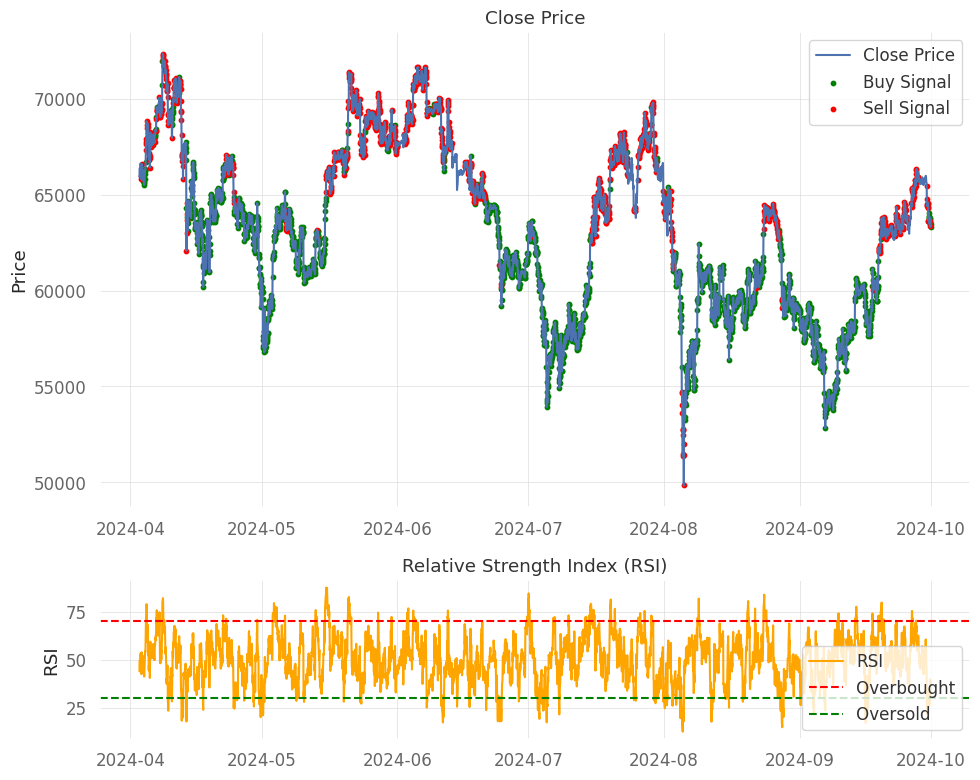

                    Strategy
------------------  ----------
Start Period        2024-04-03
End Period          2036-02-11
Risk-Free Rate      0.0%
Time in Market      61.0%

Cumulative Return   11.27%
CAGR﹪              0.62%

Sharpe              0.12
Prob. Sharpe Ratio  69.32%
Sortino             0.17
Sortino/√2          0.12
Omega               1.03

Max Drawdown        -17.14%
Longest DD Days     2190

Gain/Pain Ratio     0.03
Gain/Pain (1M)      0.15

Payoff Ratio        0.98
Profit Factor       1.03
Common Sense Ratio  1.0
CPC Index           0.52
Tail Ratio          0.97
Outlier Win Ratio   8.83
Outlier Loss Ratio  3.6

MTD                 -1.12%
3M                  -0.82%
6M                  -0.92%
YTD                 -0.82%
1Y                  2.34%
3Y (ann.)           0.71%
5Y (ann.)           -0.43%
10Y (ann.)          1.37%
All-time (ann.)     0.62%

Avg. Drawdown       -1.95%
Avg. Drawdown Days  145
Recovery Factor     0.89
Ulcer Index         0.06
Serenity Index      0.1


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


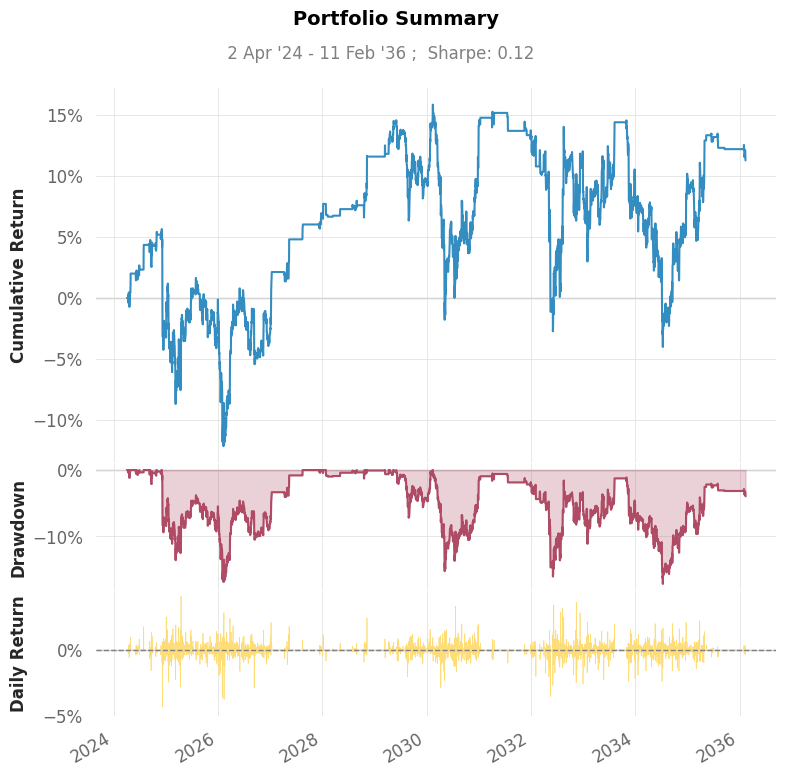

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


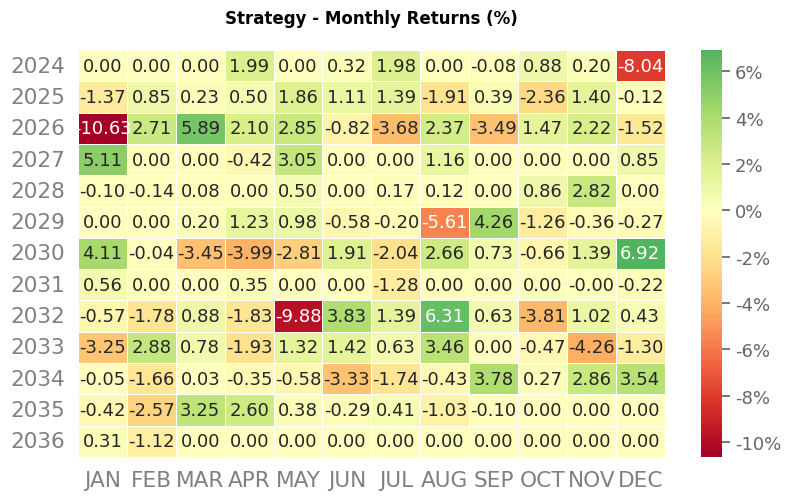

In [ ]:
import quantstats as qs

from utils.charts.plot_data_with_rsi import plot_data_with_rsi

# ====================================
# Model Evaluation (Optional)
# ====================================

test_data = fetch_data_with_indicators(Api.YAHOO, 'BTC-USD', '2024-04-01', '2024-10-01', '1h', ['RSI', 'EMA_50'])

test_data = test_data.copy()  # Make a full copy
test_data['Pct Change'] = test_data['Close'].pct_change() * 100
test_data.dropna(inplace=True)

eval_env = DummyVecEnv([lambda: CryptoTradingEnv(test_data)])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False)

portfolio_values = []

model = PPO.load('./models/best_model', env=env)

obs = eval_env.reset()
done = False
state = None
while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    obs, reward, done, info = eval_env.step(action)
    
    portfolio_values.append(info[0]['net_worth'])
    
    eval_env.render()
    
    if done:
        actions_history = info[0]['actions_history']
        print('Episode done!')
    
eval_env.close()

# ====================================
# Portfolio Analysis
# ====================================

actions_history.index = pd.to_datetime(test_data.index)

plot_data_with_rsi(actions_history)

dates = pd.date_range(start=test_data.index[0], periods=len(portfolio_values), freq="D")
portfolio_series = pd.Series(portfolio_values, index=dates)

returns = portfolio_series.pct_change().fillna(0)

qs.reports.basic(returns)

